<a href="https://colab.research.google.com/github/lisatwyw/AFib/blob/main/afib_predict_death.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brief recap

Models published and deployed below were selected based on optimal balance between size of input variable set and accuracy.


## Death risk estimation

The published version requires input of 14 types of information and achieved following performances:

### Test set:
- 1-year prediction: D-AUC of 0.804 (95% CI 0.792-0.817)
- 2-year prediction: D-AUC of 0.814 (95% CI 0.803-0.824)
- 3-year prediction: D-AUC of 0.817 (95% CI 0.808-0.827)

### Validation set A:
- 1-year prediction: D-AUC of 0.808 (95% CI 0.801-0.816)
- 2-year prediction: D-AUC of 0.810 (95% CI 0.804-0.817)
- 3-year prediction: D-AUC of 0.817 (95% CI 0.812-0.823)

### Validation set B:
- 1-year prediction: D-AUC of 0.805 (95% CI 0.797-0.812)
- 2-year prediction: D-AUC of 0.812 (95% CI 0.805-0.819)
- 3-year prediction: D-AUC of 0.818 (95% CI 0.801-0.836)



# Mount drive 

In [93]:
from google.colab import drive
drive.mount('/content/drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

subdir='AFib_2022-6-09'
try:
  os.mkdir( '/content/drive/My Drive/Colab Notebooks/%s'% subdir )
except: 
  pass  
import os
try:
  os.mkdir( '/content/drive/My Drive/Colab Notebooks/%s'% subdir )
except:
  pass  
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/%s'% subdir )

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
death_normv0_mlp_SW1.1_fa89_k13_BK2_GlU_selu_SGD_SH1_BN1_BS16_LR0.010_LRR0.01_DE0_l10.00_l20.00_DO0.08_semd+nph_wt0.80_0FD20_FS0_VS0.2_modeday_06-09.1best_CI0.95.csv
death_normv0_mlp_SW1.1_fa89_k13_BK2_GlU_selu_SGD_SH1_BN1_BS16_LR0.010_LRR0.01_DE0_l10.00_l20.00_DO0.08_semd+nph_wt0.80_0FD20_FS0_VS0.2_modeday_06-09.1best_net-ben_1YR_All0_avg.png
death_normv0_mlp_SW1.1_fa89_k13_BK2_GlU_selu_SGD_SH1_BN1_BS16_LR0.010_LRR0.01_DE0_l10.00_l20.00_DO0.08_semd+nph_wt0.80_0FD20_FS0_VS0.2_modeday_06-09.1best_net-ben_2YR_All0_avg.png
death_normv0_mlp_SW1.1_fa89_k13_BK2_GlU_selu_SGD_SH1_BN1_BS16_LR0.010_LRR0.01_DE0_l10.00_l20.00_DO0.08_semd+nph_wt0.80_0FD20_FS0_VS0.2_modeday_06-09.1best_net-ben_3YR_All0_avg.png
death_normv0_mlp_SW1.1_fa89_k13_BK2_GlU_selu_SGD_SH1_BN1_BS16_LR0.010_LRR0.01_DE0_l10.00_l20.00_DO0.08_semd+nph_wt0.80_0FD20_FS0_VS0.2_modeday_06-09.1.h5


# Install and import packages

In [ ]:
try:
  import bqplot as bq
  
except:
  !jupyter nbextension enable --py widgetsnbextension
  !pip install layout
  !pip install bqplot
  !pip install scikit-survival

  import numpy as np  
  import bqplot as bq
  
  import ipywidgets as widgets

  from ipywidgets import Button, Layout, VBox, HBox
  from ipywidgets import TwoByTwoLayout

  from IPython.display import display 

  import pandas as pd
  import sksurv
  import matplotlib.pyplot as plt
  %matplotlib inline


Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for layout: filename=layout-0.4.1-py3-none-any.whl size=38333 sha256=735200fde267866c5cb48e787a70d2889873d0d0236fee35201a105b1430f685
  Stored in directory: /root/.cache/pip/wheels/01/99/c7/0631d3192c13d4ee74b66532a12bf993dcc6200c757fab7d92
Successfully built layout
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 4.9 MB/s 


# Display interactive simple interface for accepting user's inputs

In [87]:
w_age = widgets.IntSlider(value=60,description='Age:')

w_age_sepsis = widgets.IntSlider(max=w_age.value,description='Age when last hospitalized with sepsis (prior to AF Dx)')
w_age_cancer = widgets.IntSlider(max=w_age.value,description='Age when diagnosed with cancer (prior to AF Dx)')

med_hx_items={}
med_hx_items[0] = ['Male sex']
med_hx_items[1] = ['Has COPD', 'Has cardiovascular disease', 'Has congestive heart failure']
med_hx_items[2] = ['Has cancer', 'Has metastatic caricnoma']
med_hx_items[3] = ['Has dementia','Hospitalized before due to life management difficulties (injuries at care home)',
                   'Hospitalized before due to disorders of fluid electrolyte, volume depletion', 'Hospitalization due to brain injuries' ]
med_hx_items[4] = ['Age when diagnosed with cancer prior to AF Dx', 'Age of last sepsis prior to AF Dx' ]
med_hx_items[5] = ['Diuretic loop: # of days prescribed with diuretic loop prior to AF Dx' ]
hx_widgets = {}
for i in range( len(med_hx_items) ):
  hx_widgets[i] =[] 

  for m in med_hx_items[i]:  
    print( i, m )
    w = widgets.ToggleButton(
      value=False,
      description=m,
      disabled=False,
      button_style='', # 'success', 'info', 'warning', 'danger' or ''
      tooltip='Description',
      icon='check' # (FontAwesome names without the `fa-` prefix)
    )
    hx_widgets[i].append(w)

c1 = VBox(hx_widgets[1])
c2 = VBox(hx_widgets[2])
c3 = VBox(hx_widgets[3])
c4 = VBox(hx_widgets[4])
c5 = VBox(hx_widgets[5])
c0 = VBox(hx_widgets[0])
display( HBox([c0,c1,c2,c3,c4,c5]) )
display(w_age)

0 Male sex
1 Has COPD
1 Has cardiovascular disease
1 Has congestive heart failure
2 Has cancer
2 Has metastatic caricnoma
3 Has dementia
3 Hospitalized before due to life management difficulties (injuries at care home)
3 Hospitalized before due to disorders of fluid electrolyte, volume depletion
3 Hospitalization due to brain injuries
4 Age when diagnosed with cancer prior to AF Dx
4 Age of last sepsis prior to AF Dx
5 Diuretic loop: # of days prescribed with diuretic loop prior to AF Dx


IntSlider(value=60, description='Age:')

In [88]:
for i in range( len(med_hx_items) ):
  for m in hx_widgets[i]:
    if m.value:
      if m.description=='Age when diagnosed with cancer prior to AF Dx':
        display(w_age_cancer)
      if m.description=='Age of last sepsis prior to AF Dx':
        display(w_age_sepsis)

IntSlider(value=0, description='Age when diagnosed with cancer (prior to AF Dx)', max=60)

IntSlider(value=0, description='Age when last hospitalized with sepsis (prior to AF Dx)', max=60)

# Summarize user's inputs before generating predictions

In [89]:
Is_Male=1
Age=w_age.value
Age_sepsis=w_age.value
Age_sepsis=Age_cancer=0

Has_COPD=Has_CHF=Has_CVD=Has_Cancer=Has_Carcinoma=Has_Dementia=Had_Brain=Had_Fluid=Had_CareIssues=0
print( 'Calculating risk of patient (age=%d) with following medical history:\n'% w_age.value )
for i in range( len(med_hx_items) ):
  for m in hx_widgets[i]:
    if m.description=='Age when diagnosed with cancer prior to AF Dx':
      print(w_age_cancer.value , end=' <-- ' )
      Age_cancer=w_age_cancer.value
    
    if m.description=='Age of last sepsis prior to AF Dx':
      print( w_age_sepsis.value, end=' <-- ')  
      Age_sepsis=w_age_sepsis.value
    
    if m.value:
      if 'COPD' in m.description:
        Has_COPD=1
      if 'heart' in m.description:
        Has_CHF=1        
      if 'cardio' in m.description:
        Has_CVD=1  

      if 'carcinoma' in m.description:
        Has_Carcinoma=1
      if 'cancer' in m.description:
        Has_Cancer=1
      
      if 'brain' in m.description:
        Had_Brain=1
      if 'fluid' in m.description:
        Had_Fluid=1
      if 'life' in m.description:
        Had_CareIssues=1
      
      if 'dementia' in m.description:
        Has_Dementia=1

      if 'Male' in m.description:
        Is_Male=2  
      print( m.description )

Calculating risk of patient (age=81) with following medical history:

Male sex
Has COPD
39 <-- Age when diagnosed with cancer prior to AF Dx
50 <-- Age of last sepsis prior to AF Dx


In [67]:
ev='death'
sample_data_death = np.asarray( [[79,0,0,1,0,0,1,0,30,0,0,0,0,0,0], 
                                 [80,0,0,0,1,0,1,0, 0,1,0,1,0,0,0], 
                                 [82,0,0,0,0,0,2,0, 0,1,0,0,1,0,0],
                                 [92,0,0,0,0,0,1,0, 0,0,0,0,0,81,0],
                                 [43,0,0,0,0,0,2,0, 0,0,0,0,0,0,0],
                                 [73,0,0,0,0,0,2,0, 0,0,0,0,0,0,0],
                                 [62,0,0,0,0,0,2,0, 0,1,0,0,1,0,0],
                                 [81,0,0,0,0,0,2,0, 0,0,0,0,0,0,0] ])
                                  
Samples[ev]=pd.DataFrame( sample_data_death, columns=['Age', 'CCI_carcinoma', 'dementia', 'CCI_CHF', 'CCI_COPD', 'CCI_cancer','SEX', 'rx_n_90d_prior_diuretic_loop', 'rx_n_365d_prior_diuretic_loop','CCI_CVD', 'FRL_care', 'FRL_chemistry','FRL_brain', 'b4dx_age_sepsis','b4dx_age_cancer'] )


Samples[ev]['Time2Event']=(np.asarray( [2071, 117, 8, 974,    1717, 1574, 3056, 164]) < query_time_endpoint).astype(int)
Samples[ev]['Event?']=(np.asarray( [1,1,1,1, 0,0,0,0])).astype(int)
Samples[ev]['Event?']=Samples[ev]['Event?']* Samples[ev]['Time2Event']
Samples[ev].transpose()


,0,1,2,3,4,5,6,7
Age,79,80,82,92,43,73,62,81
CCI_carcionma,0,0,0,0,0,0,0,0
dementia,0,0,0,0,0,0,0,0
CCI_CHF,1,0,0,0,0,0,0,0
CCI_COPD,0,1,0,0,0,0,0,0
CCI_cancer,0,0,0,0,0,0,0,0
SEX,1,1,2,1,2,2,2,2
rx_n_90d_prior_diuretic_loop,0,0,0,0,0,0,0,0
rx_n_365d_prior_diuretic_loop,30,0,0,0,0,0,0,0
CCI_CVD,0,1,1,0,0,0,1,0


In [90]:
curr_pt_data =np.asarray([Age,Has_Carcinoma,Has_Dementia,Has_CHF,Has_COPD,Has_Cancer,Is_Male,\
                          Has_CVD,Had_CareIssues,Had_Fluid,Had_Brain,Age_sepsis, Age_cancer] ).reshape(1,-1)

In [108]:
models = {}
filenames={}
filenames['death']='death_normv0_cox_SW1.1_fa89_k13__0FD20_FS0_VS0.3_modeday_06-09.1_model.pkl'

surv_preds = {}

def readpkl( filename ):
  from pickle import load
  file=open(filename,'rb')
  dat = load(file)
  return dat

for ev in ['death']:
  m=readpkl(filenames[ev] )
  try:
    models[ev] =m['model']
  except:
    models[ev] =m
    


******************************************************************************************************************************************************************************************************************
casting predictions on death
Sample patient 0 has cumulative risks of {0.30,0.45,0.61} for event at years 1,2,3


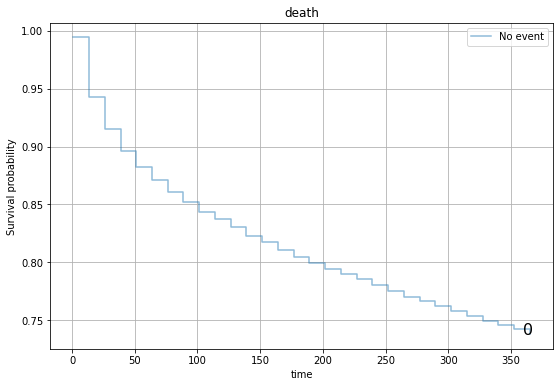

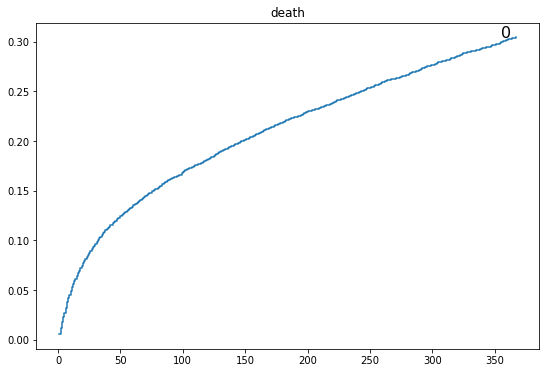

In [111]:
time_points = np.linspace( 1, query_time_endpoint, 30)
#time_points = np.asarray( [1,12,44,120,249,445,671,894,1128,1367])  # np.quantile(  time2event[sets[0]][event_happend[0]==1], linspace(0,.6,10) )
fsz=16

for ev in ['death']:
  
  if 0:
    curr_pt_data = Samples[ev].drop('Event?',axis=1) 
    curr_pt_data = curr_pt_data.drop('Time2Event',axis=1) 
    curr_pt_data.transpose()

  print('**'*105)
  print( 'casting predictions on', ev )

  surv_fns= models[ev].predict_survival_function( curr_pt_data )
  chf_fns = models[ev].predict_cumulative_hazard_function( curr_pt_data )


  def draw_survival_fns( surv_fns, df, time_points ):
      legend_handles = []
      legend_labels = []
      
      _, ax = plt.subplots(figsize=(9, 6))    
      i=-1
      for fn, label in zip(surv_fns, df.loc[:, "Event?"].astype(int)):
          i+=1
          l, = ax.step(time_points, fn(time_points), where="post",
                        color="C{:d}".format(label), alpha=0.5)
          
          plt.text( l._x[-1]-20*np.random.random(1), l._y[-1], '%d'%i, fontsize=fsz );          
          if len(legend_handles) <= label:
              name = "Event observed" if label == 1 else "No event"
              legend_labels.append(name)
              legend_handles.append(l)

      ax.legend(legend_handles, legend_labels)
      ax.set_xlabel("time")
      ax.set_ylabel("Survival probability")
      ax.grid(True)
      ax.set_title(ev)
      
  draw_survival_fns( surv_fns, Samples[ev], time_points )

  def draw_cum_hazard_fns( chf_fns ):
    _, ax = plt.subplots(figsize=(9, 6))

    for i,fn in enumerate(  chf_fns ):
        _, ax.step(fn.x[:365*NYRS], fn(fn.x[:365*NYRS]), where="post");
        
        n=len(fn.x[:365*NYRS])

        r1,r2,r3= fn(fn.x[:365])[-1], fn(fn.x[:2*365])[-1], fn(fn.x[:365*3][-1]) 
        print( 'Sample patient {0} has cumulative risks of {{{1:.2f},{2:.2f},{3:.2f}}} for event at years 1,2,3'.format( i, r1,r2,r3 )  )   
        ax.text( n-20*np.random.random(1), fn(fn.x[:NYRS*365])[-1], '%d'%i, fontsize=fsz );      
        
        #ax.set_ylim(0,1)  
        ax.grid( axis='both', b=True, which='minor', color='grey', linestyle='-')
        ax.set_title(ev)

  draw_cum_hazard_fns( chf_fns )     